In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
import tensorflow as tf
from pathlib import Path
from time import strftime, time
from shutil import rmtree
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
#matplotlib.use("TKAgg", force=True)
%matplotlib inline
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.plotting.plotting import plot_sequences, plot_nn_metrics
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_from_pvalue, get_sigma_for_ts_array, get_sigma_from_ts
from rtapipe.lib.utils.notebook import *
from sagsci.tools.utils import get_obs_pointing
from sagsci.wrappers.rtaph.photometry import Photometrics
from rtapipe.lib.utils.notebook import *

# Loading the models

In [3]:
def load_model(model_id):
    with open("./trained_models.yaml", "r") as f:
        try:
            configs = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
    model_config = [c for c in configs["models"] if c["id"] == model_id]
    model_config = dotdict(model_config.pop())
    model_config.ad = AnomalyDetectorBuilder.getAnomalyDetector(name=model_config.name, timesteps=model_config.timesteps, nfeatures=model_config.nfeatures, load_model="True", training_epoch_dir=model_config.path, training=False)
    model_config.pvalue_table = get_pval_table(model_config.pval_path) 
    return model_config

In [4]:
model_config_cnn = load_model(0)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 0,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19',
 'epoch': 19,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19/pvalues/pval_20221118-113940/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2aae01d95df0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.003171       0.000

In [5]:
model_config_cnn.ad.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 32)             320       
_________________________________________________________________
dropout (Dropout)            (None, 3, 32)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 32)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 5, 3)              291       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 3)              0         
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_config_rnn = load_model(1)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 1,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10',
 'epoch': 10,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10/pvalues/pval_20221121-132236/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2aaf2f3380a0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000227       0.000

In [7]:
model_config_rnn.ad.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 32)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5, 32)             2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 3)              99        
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
____________________________________________________

# Loading the test dataset

In [8]:
output_dir = "./logs/test_models_dataset_test_set_all_itime_5"

In [9]:
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]

In [10]:
data_manager = DataManager(output_dir)

In [11]:
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/test_set_all/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=500)
test_set_size = len(fits_files)

Loaded 419 files


In [12]:
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 5
number_of_energy_bins = 3
tsl = 100
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(5, 100)

[2023-01-28 11:49:07.324058] Loaded data from logs/test_models_dataset_test_set_all_itime_5/data_cache. Loaded 419 templates.


In [13]:
assert len(data_manager.data) == test_set_size

## Plot some samples

In [14]:
#for template in list(data_manager.data.keys())[0:5]:
#    data_manager.plot_timeseries(template, data_manager.data[template], 1, sim_params, output_dir, labels=features_names)

# TESTING

In [15]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [16]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2023-01-28 11:49:07.563080] Total x shape shape: (40224, 5, 3)
[2023-01-28 11:49:07.563131] Total y shape shape: (40224,)


In [17]:
test_all_y.sum()

20531

# P-value tables

## RNN

In [18]:
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

threshold        pvalue    pvalue_err  sigma
0    0.000227  1.416930e-01  1.254772e-04  1.073
1    0.000253  9.859137e-02  1.046671e-04  1.290
2    0.000279  6.802256e-02  8.693953e-05  1.491
3    0.000305  4.666059e-02  7.200554e-05  1.678
4    0.000331  3.223601e-02  5.984963e-05  1.849
..        ...           ...           ...    ...
87   0.002495  1.111173e-07  1.111173e-07  5.180
88   0.002521  1.111173e-07  1.111173e-07  5.180
89   0.002547  1.111173e-07  1.111173e-07  5.180
90   0.002574  1.111173e-07  1.111173e-07  5.180
91   0.002600  1.111173e-07  1.111173e-07  5.180

[92 rows x 4 columns]

In [19]:
tmpdf=model_config_rnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0.99)   & 
    (tmpdf['sigma'] < 1.1) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.1) |
    (tmpdf['sigma'] > 3.4) &
    (tmpdf['sigma'] < 3.6) |
    (tmpdf['sigma'] > 3.9) &
    (tmpdf['sigma'] < 4.1) |
    (tmpdf['sigma'] > 4.4) &
    (tmpdf['sigma'] < 4.6) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_rnn.tex")
! cat pvalue_table.tex

\begin{tabular}{lrrrr}
\toprule
{} &  threshold &        pvalue &    pvalue\_err &  sigma \\
\midrule
0  &   0.003171 &  1.283972e-01 &  1.201785e-04 &  1.134 \\
4  &   0.003751 &  6.115264e-02 &  8.293861e-05 &  1.545 \\
9  &   0.004476 &  2.277199e-02 &  5.061155e-05 &  2.000 \\
16 &   0.005492 &  5.323285e-03 &  2.447028e-05 &  2.554 \\
23 &   0.006507 &  1.228234e-03 &  1.175411e-05 &  3.029 \\
31 &   0.007667 &  2.312711e-04 &  5.100465e-06 &  3.502 \\
41 &   0.009118 &  3.149606e-05 &  1.882250e-06 &  4.001 \\
53 &   0.010859 &  3.262092e-06 &  6.057553e-07 &  4.509 \\
73 &   0.013760 &  4.499438e-07 &  2.249719e-07 &  4.912 \\
74 &   0.013905 &  2.249719e-07 &  1.590791e-07 &  5.047 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_220255/1959280081.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_rnn.tex")


## CNN

In [20]:
tmpdf=model_config_cnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 1)   & 
    (tmpdf['sigma'] < 1.2) |
    (tmpdf['sigma'] > 1.45) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.95) &
    (tmpdf['sigma'] < 2.084) |
    (tmpdf['sigma'] > 2.481) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.97) &
    (tmpdf['sigma'] < 3.09) |
    (tmpdf['sigma'] > 3.49) &
    (tmpdf['sigma'] < 3.555) |
    (tmpdf['sigma'] > 3.961) &
    (tmpdf['sigma'] < 4.051) |
    (tmpdf['sigma'] > 4.463) &
    (tmpdf['sigma'] < 4.51) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.048) 
]


tmpdf.to_latex("pvalue_table_cnn.tex")
! cat pvalue_table.tex

/tmp/ipykernel_220255/1294718993.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_cnn.tex")


\begin{tabular}{lrrrr}
\toprule
{} &  threshold &        pvalue &    pvalue\_err &  sigma \\
\midrule
0  &   0.003171 &  1.283972e-01 &  1.201785e-04 &  1.134 \\
4  &   0.003751 &  6.115264e-02 &  8.293861e-05 &  1.545 \\
9  &   0.004476 &  2.277199e-02 &  5.061155e-05 &  2.000 \\
16 &   0.005492 &  5.323285e-03 &  2.447028e-05 &  2.554 \\
23 &   0.006507 &  1.228234e-03 &  1.175411e-05 &  3.029 \\
31 &   0.007667 &  2.312711e-04 &  5.100465e-06 &  3.502 \\
41 &   0.009118 &  3.149606e-05 &  1.882250e-06 &  4.001 \\
53 &   0.010859 &  3.262092e-06 &  6.057553e-07 &  4.509 \\
73 &   0.013760 &  4.499438e-07 &  2.249719e-07 &  4.912 \\
74 &   0.013905 &  2.249719e-07 &  1.590791e-07 &  5.047 \\
\bottomrule
\end{tabular}


# RNN

## Evaluate metrics for different trehsholds

In [21]:
metrics_rnn = evaluate_metrics(model_config_rnn, test_all_x, test_all_y, output_dir, "metrics_rnn.pickle", additional_tresholds=[0.000025, 0.000050, 0.000075])

Loading metrics_rnn.pickle from logs/test_models_dataset_test_set_all_itime_5/metrics_rnn.pickle...


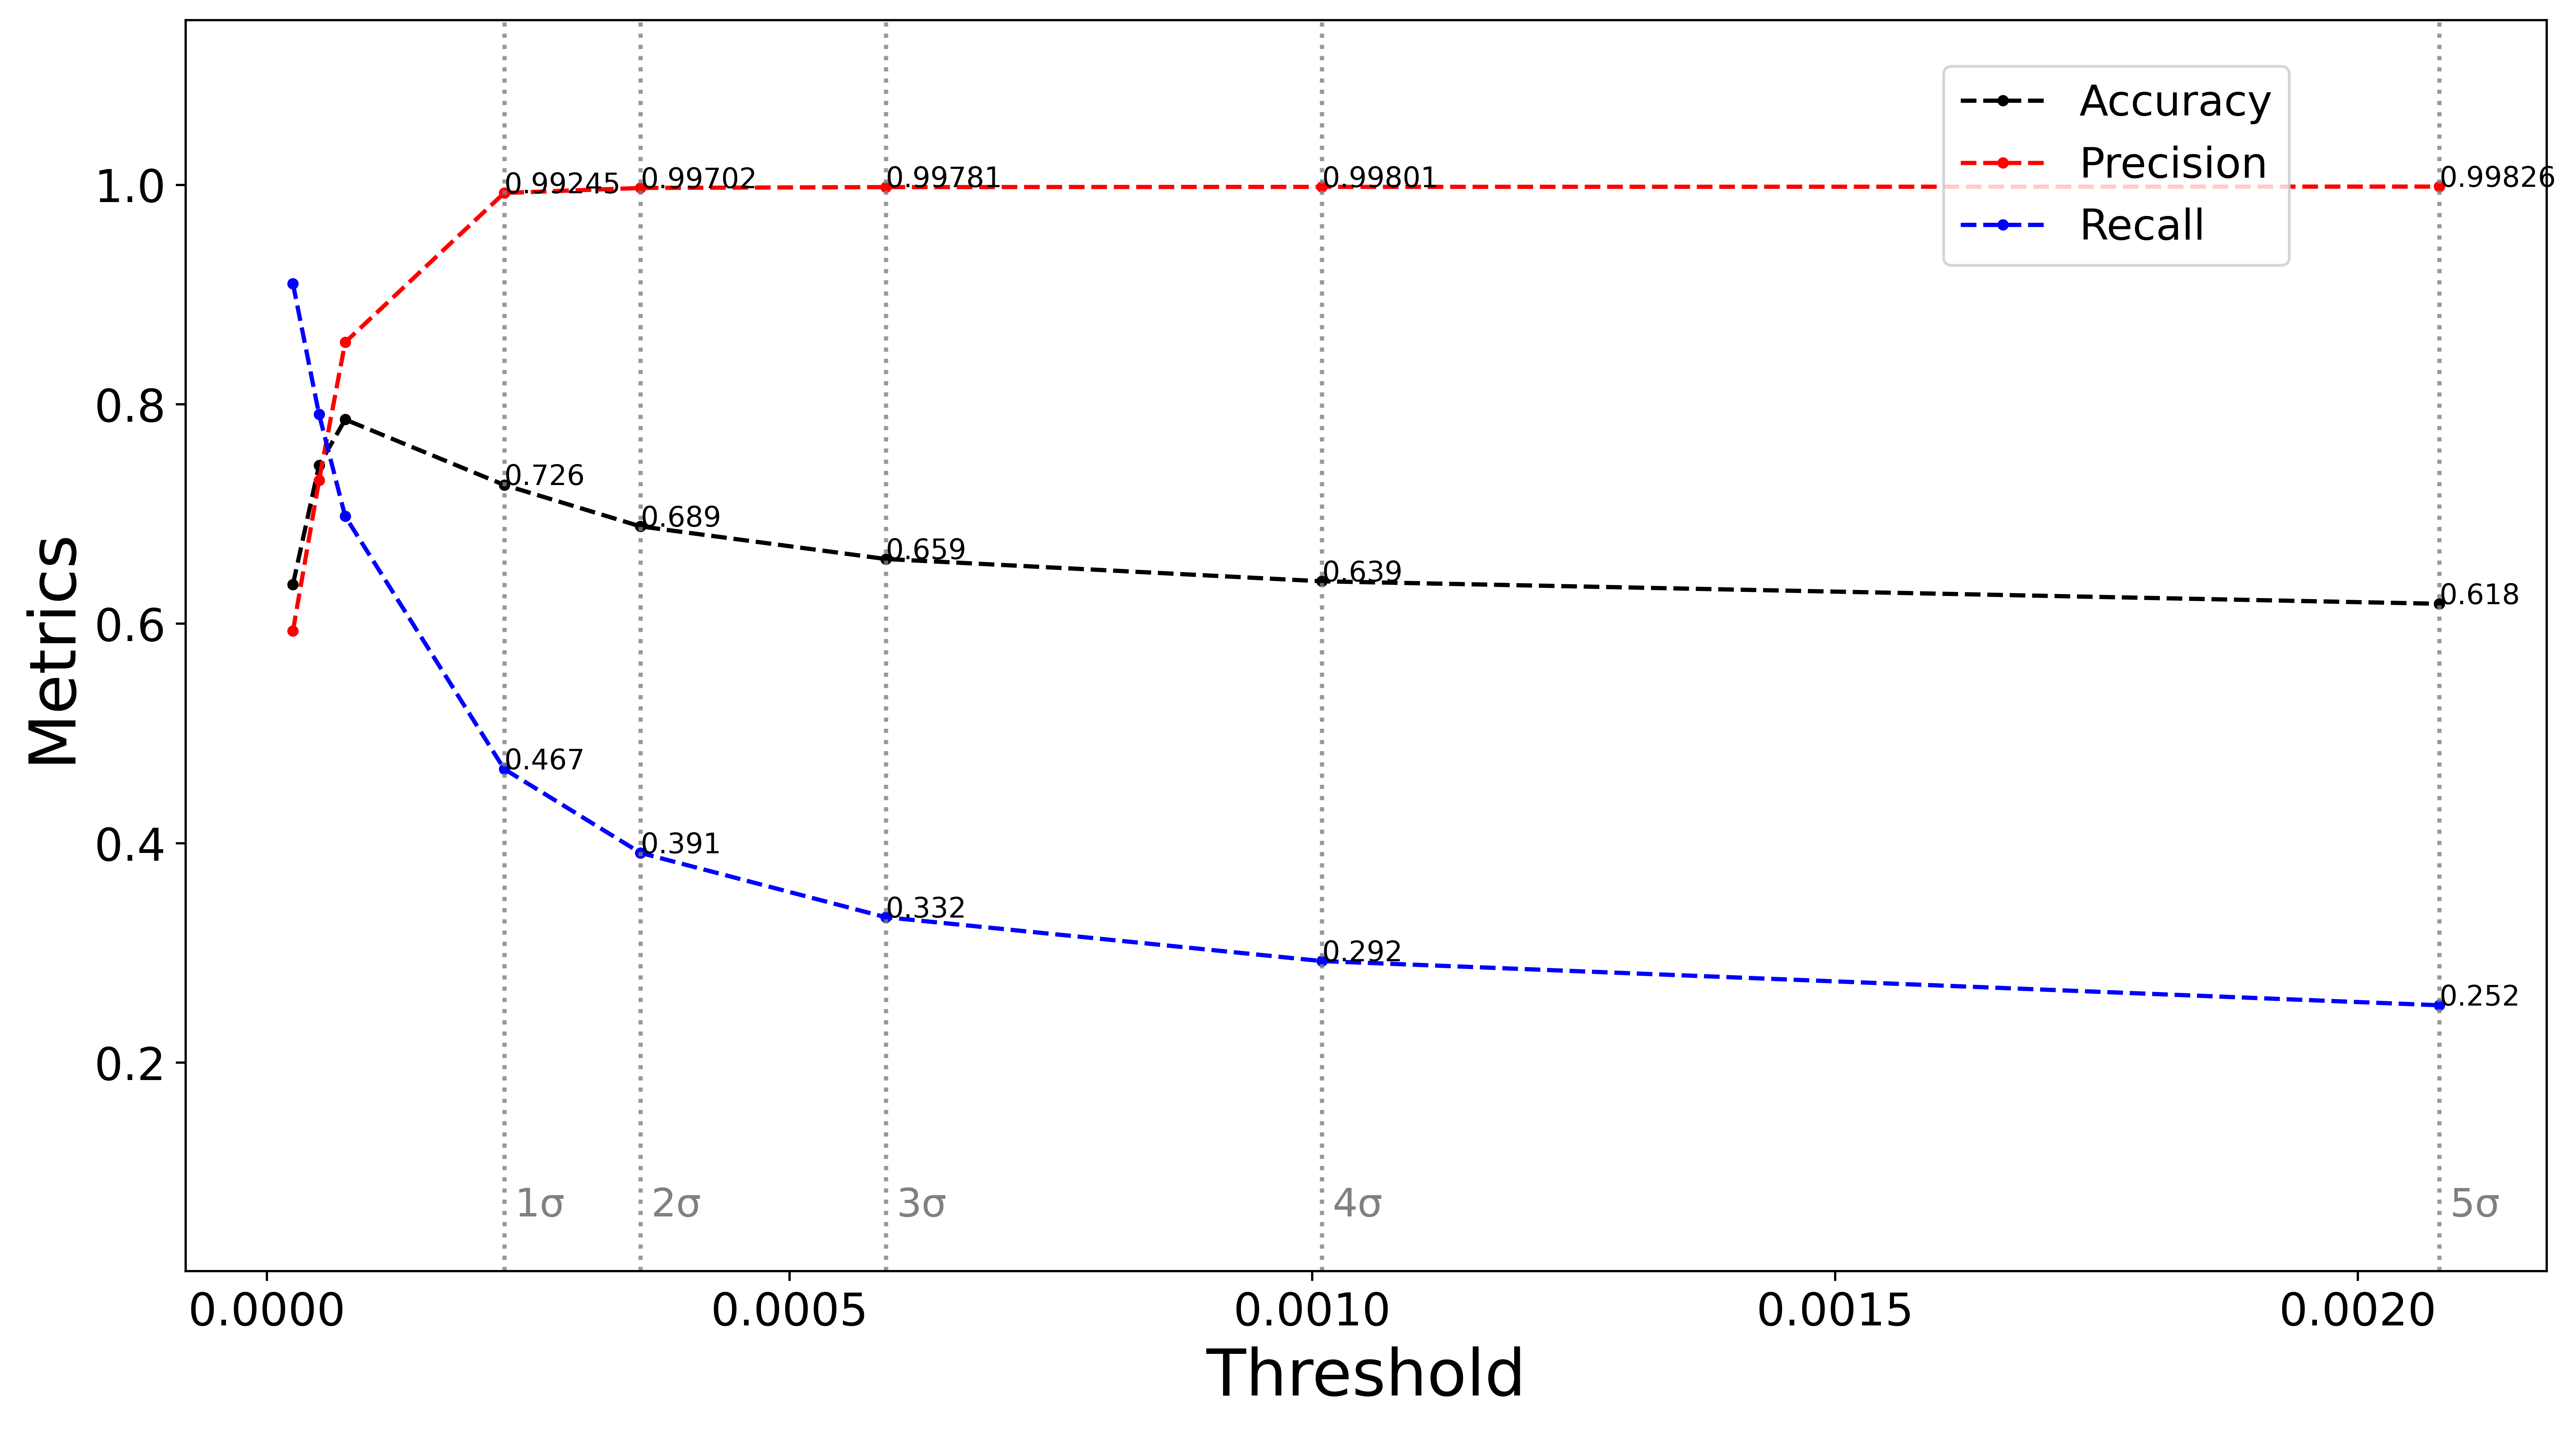

Saved figure to:  logs/test_models_dataset_test_set_all_itime_5/rnn_metrics_test_set_all_itime_5.png


In [22]:
%matplotlib inline
plot_nn_metrics(metrics_rnn, model_config_rnn, output_dir, fig_name="rnn_metrics_test_set_all_itime_5", y_lim=(0.01, 1.15), annotate_after=3, showFig=True, saveFig=True)

## Standard metrics - 5 sigma threshold

In [23]:
SIGMA_THRESHOLD = 5

In [24]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.0020782086315 corresponding to 5.0488536162 sigma


In [25]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0020782086315
accuracy 0.6180887032617343
precision 0.9982648930017352
recall 0.25220398421898593
f1 0.402675169142235
roc_auc 0.6258734845179631
confusion_matrix [[19684, 9], [15353, 5178]]
false_positive_rate 0.001735106998264893
detection_delay: 2.4463007159904535


## Sigma table

In [26]:
def crop_to_5(s):
    if s > 5: 
        s = 5.00001
    return s

In [27]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_rnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)

100%|██████████| 419/419 [00:24<00:00, 17.23it/s]


In [28]:
sigma_table_rnn

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25                  0.0          0.000000          0.000000   
5-30                  0.0          0.000000          0.000000   
10-35                 0.0          0.000000          0.000000   
15-40                 0.0          0.000000          0.000000   
20-45                 0.0          0.000000          0.000000   
...                   ...               ...               ...   
455-480               0.0          3.340322          0.000000   
460-485               0.0          3.123477          0.000000   
465-490               0.0          0.000000          0.000000   
470-495               0.0          0.000000          1.719958   
475-500               0.0          0.000000          0.000000   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25                    0          0.000000                 0   
5-30                    0          0.000000                 0   
10-35                   0          0.000000                 0   
15-40                   0          0.000000                 0   
20-45                   0          0.000000                 0   
...                   ...               ...               ...   
455-480                 0          0.000000                 0   
460-485                 0          0.000000                 0   
465-490                 0          0.000000                 0   
470-495                 0          0.000000                 0   
475-500                 0          1.197792                 0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25                  0.0          0.000000               0.0   
5-30                  0.0          0.000000               0.0   
10-35                 0.0          0.000000               0.0   
15-40                 0.0          0.000000               0.0   
20-45                 0.0          0.000000               0.0   
...                   ...               ...               ...   
455-480               0.0          4.297206               0.0   
460-485               0.0          4.224088               0.0   
465-490               0.0          4.190291               0.0   
470-495               0.0          3.969708               0.0   
475-500               0.0          3.544812               0.0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25              0.00000           0.00000                 0   
5-30              0.00000           0.00000                 0   
10-35             0.00000           0.00000                 0   
15-40             0.00000           0.00000                 0   
20-45             0.00000           0.00000                 0   
...                   ...               ...               ...   
455-480           5.00001           5.00001                 0   
460-485           5.00001           5.00001                 0   
465-490           5.00001           5.00001                 0   
470-495           5.00001           5.00001                 0   
475-500           5.00001           4.97082                 0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25                    0               0.0          0.000000   
5-30                    0               0.0          0.000000   
10-35                   0               0.0          1.543997   
15-40                   0               0.0          0.000000   
20-45                   0               0.0          0.000000   
...                   ...               ...               ...   
455-480                 0               0.0          0.000000   
460-485                 0               0.0          0.000000   
465-490                 0               0.0          1.425664   
470-495                 0               0.0          0.000000   
475-500                 0               0.0          0.000000   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25                    0              

# CNN

In [29]:
metrics_cnn = evaluate_metrics(model_config_cnn, test_all_x, test_all_y, output_dir, "metrics_cnn.pickle", additional_tresholds=[0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.002])

Loading metrics_cnn.pickle from logs/test_models_dataset_test_set_all_itime_5/metrics_cnn.pickle...


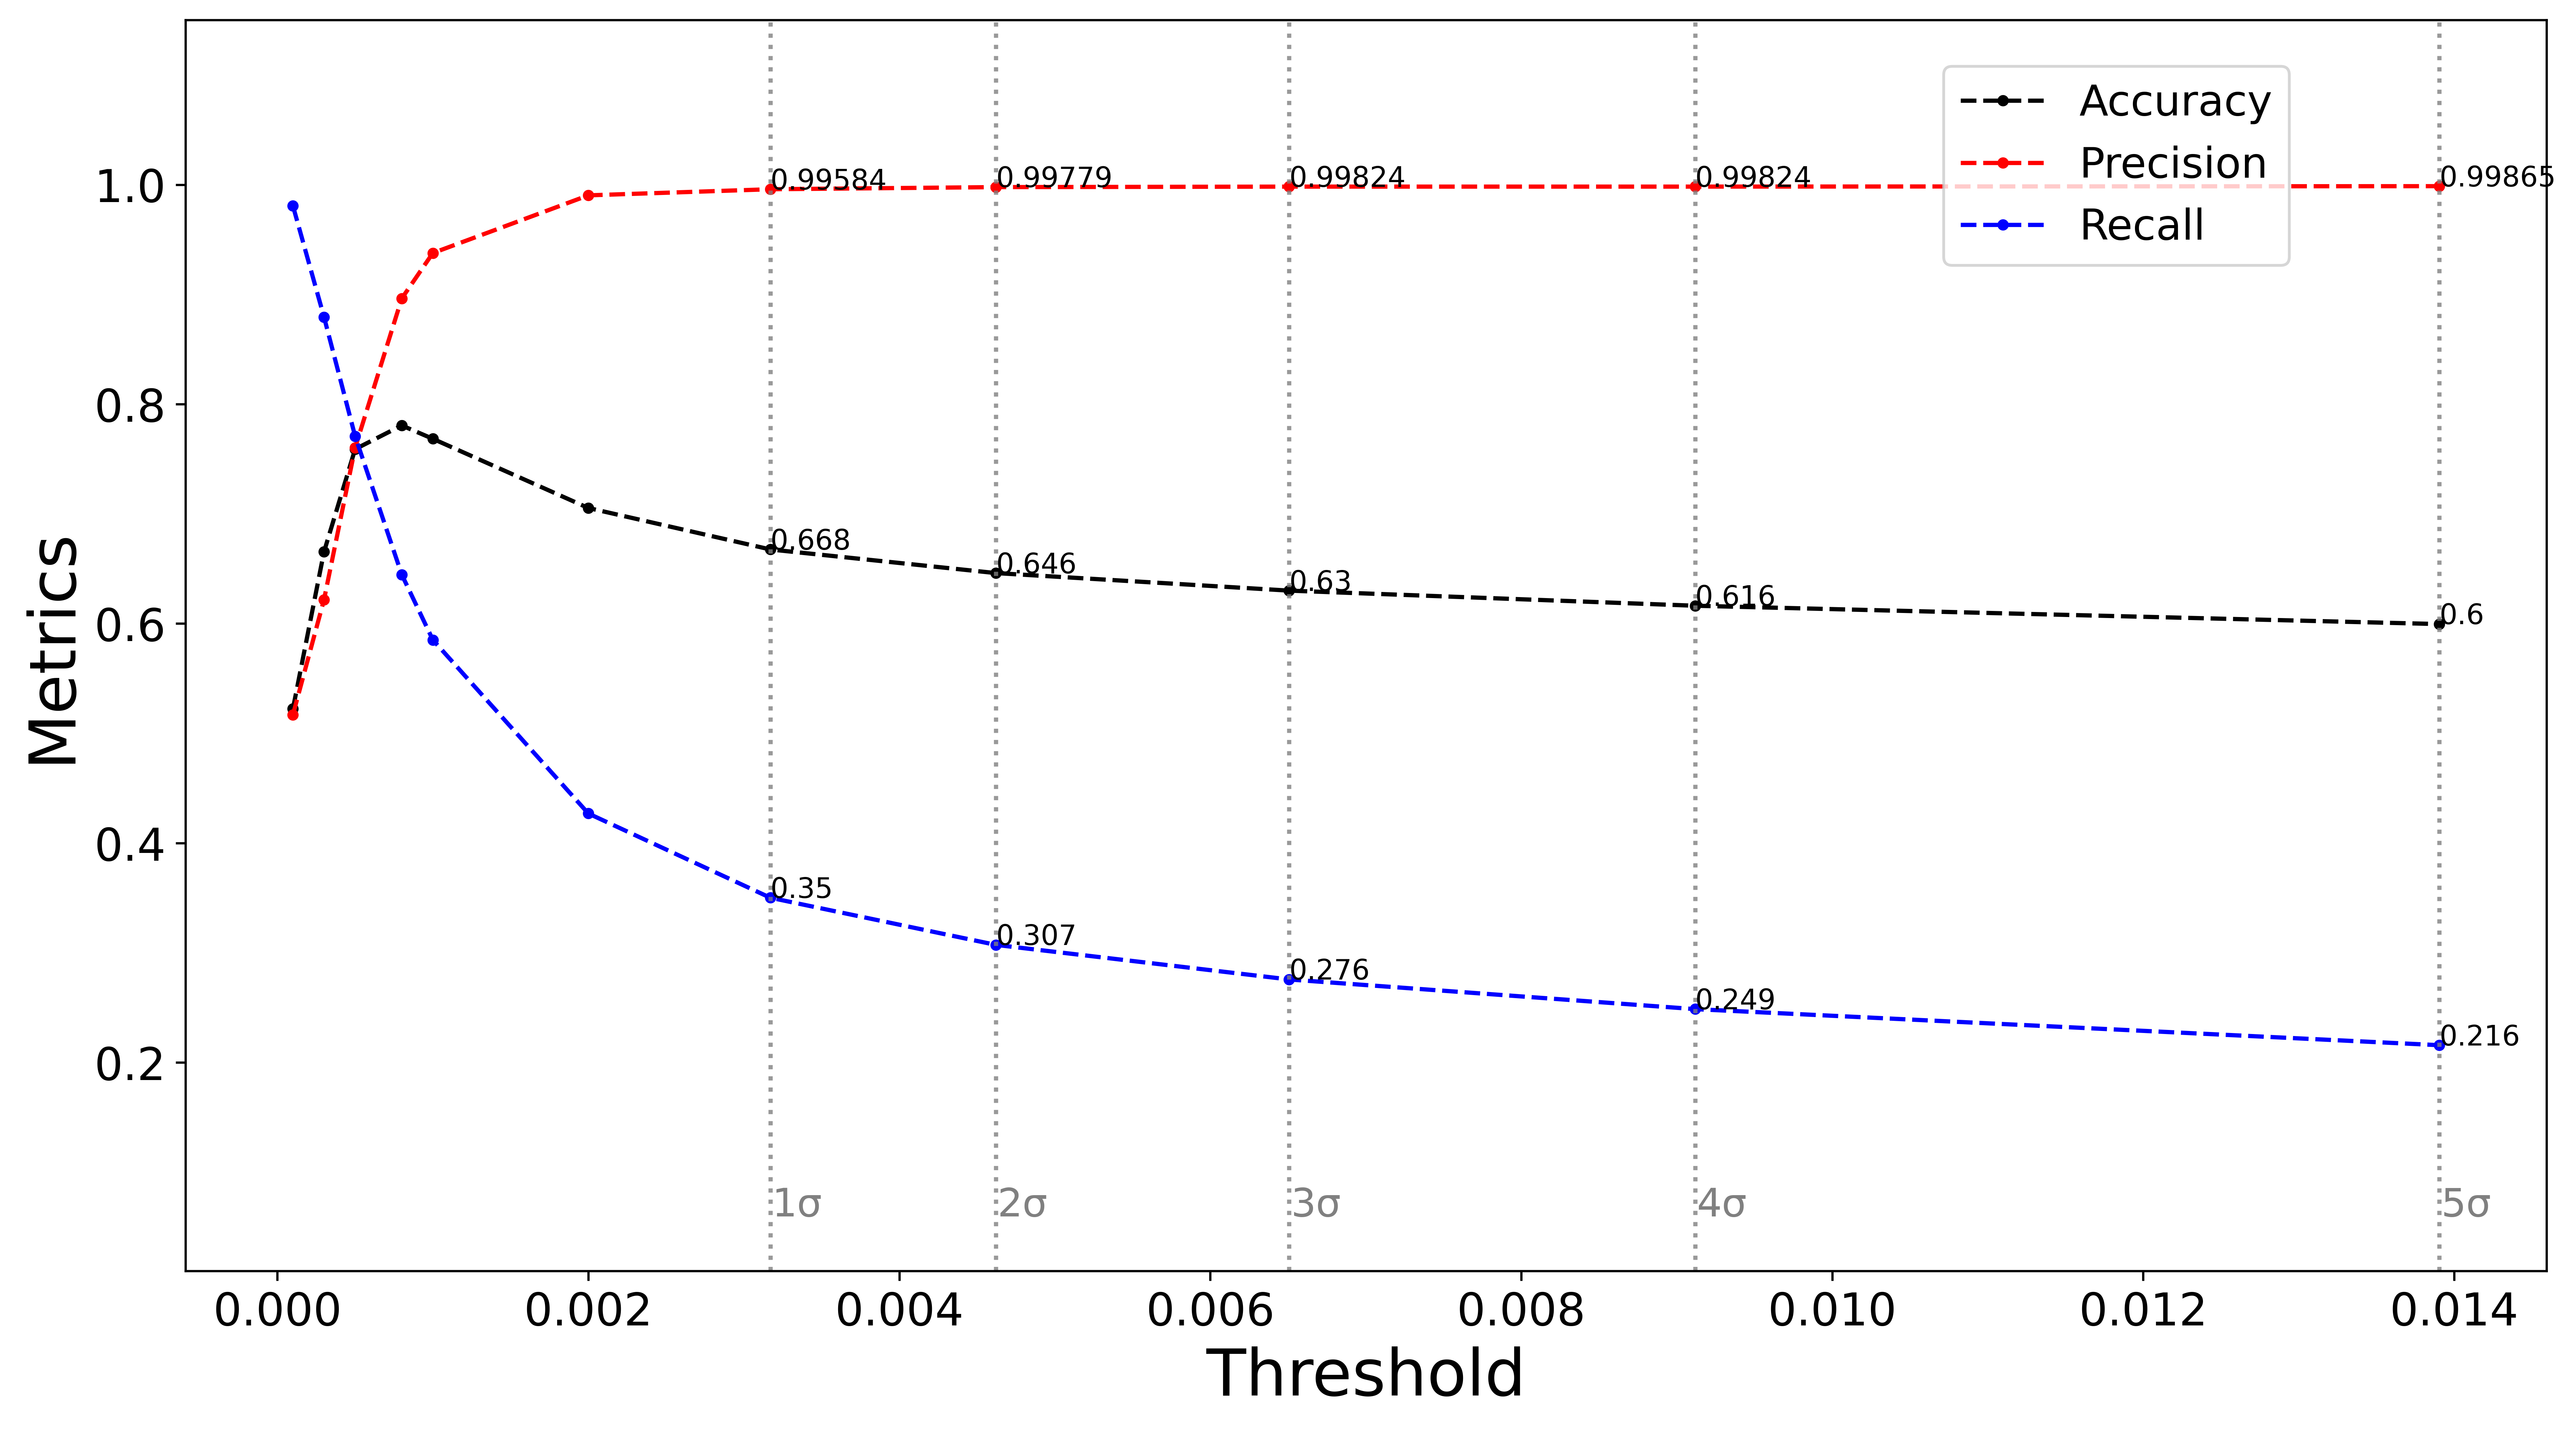

Saved figure to:  logs/test_models_dataset_test_set_all_itime_5/cnn_metrics_test_set_all_itime_5.png


In [30]:
plot_nn_metrics(metrics_cnn, model_config_cnn, output_dir, fig_name="cnn_metrics_test_set_all_itime_5", annotate_after=6, y_lim=(0.01, 1.15), showFig=True, saveFig=True)

## Standard metrics - 5 sigma

In [31]:
SIGMA_THRESHOLD = 5

In [32]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.0139048776129999 corresponding to 5.0465140766 sigma


In [33]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.0139048776129999
accuracy 0.5995922832140016
precision 0.9986477349560514
recall 0.2158199795431299
f1 0.35493431592438324
roc_auc 0.6077576513772116
confusion_matrix [[19687, 6], [16100, 4431]]
false_positive_rate 0.001352265043948614
detection_delay: 2.360381861575179


## Sigma table

In [34]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_cnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)
sigma_table_cnn

100%|██████████| 419/419 [00:22<00:00, 18.99it/s]


run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25                  0.0                 0                 0   
5-30                  0.0                 0                 0   
10-35                 0.0                 0                 0   
15-40                 0.0                 0                 0   
20-45                 0.0                 0                 0   
...                   ...               ...               ...   
455-480               0.0                 0                 0   
460-485               0.0                 0                 0   
465-490               0.0                 0                 0   
470-495               0.0                 0                 0   
475-500               0.0                 0                 0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25                    0                 0                 0   
5-30                    0                 0                 0   
10-35                   0                 0                 0   
15-40                   0                 0                 0   
20-45                   0                 0                 0   
...                   ...               ...               ...   
455-480                 0                 0                 0   
460-485                 0                 0                 0   
465-490                 0                 0                 0   
470-495                 0                 0                 0   
475-500                 0                 0                 0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25                  0.0          0.000000                 0   
5-30                  0.0          0.000000                 0   
10-35                 0.0          0.000000                 0   
15-40                 0.0          0.000000                 0   
20-45                 0.0          0.000000                 0   
...                   ...               ...               ...   
455-480               0.0          1.993607                 0   
460-485               0.0          2.534140                 0   
465-490               0.0          2.869506                 0   
470-495               0.0          3.109056                 0   
475-500               0.0          1.631926                 0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25              0.00000          0.000000                 0   
5-30              0.00000          0.000000                 0   
10-35             0.00000          0.000000                 0   
15-40             0.00000          0.000000                 0   
20-45             0.00000          0.000000                 0   
...                   ...               ...               ...   
455-480           5.00001          4.868434                 0   
460-485           5.00001          3.882413                 0   
465-490           5.00001          2.832759                 0   
470-495           5.00001          4.750939                 0   
475-500           5.00001          4.569269                 0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25                    0               0.0                 0   
5-30                    0               0.0                 0   
10-35                   0               0.0                 0   
15-40                   0               0.0                 0   
20-45                   0               0.0                 0   
...                   ...               ...               ...   
455-480                 0               0.0                 0   
460-485                 0               0.0                 0   
465-490                 0               0.0                 0   
470-495                 0               0.0                 0   
475-500                 0               0.0                 0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25                    0              

In [35]:
sigma_table_cnn

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25                  0.0                 0                 0   
5-30                  0.0                 0                 0   
10-35                 0.0                 0                 0   
15-40                 0.0                 0                 0   
20-45                 0.0                 0                 0   
...                   ...               ...               ...   
455-480               0.0                 0                 0   
460-485               0.0                 0                 0   
465-490               0.0                 0                 0   
470-495               0.0                 0                 0   
475-500               0.0                 0                 0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25                    0                 0                 0   
5-30                    0                 0                 0   
10-35                   0                 0                 0   
15-40                   0                 0                 0   
20-45                   0                 0                 0   
...                   ...               ...               ...   
455-480                 0                 0                 0   
460-485                 0                 0                 0   
465-490                 0                 0                 0   
470-495                 0                 0                 0   
475-500                 0                 0                 0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25                  0.0          0.000000                 0   
5-30                  0.0          0.000000                 0   
10-35                 0.0          0.000000                 0   
15-40                 0.0          0.000000                 0   
20-45                 0.0          0.000000                 0   
...                   ...               ...               ...   
455-480               0.0          1.993607                 0   
460-485               0.0          2.534140                 0   
465-490               0.0          2.869506                 0   
470-495               0.0          3.109056                 0   
475-500               0.0          1.631926                 0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25              0.00000          0.000000                 0   
5-30              0.00000          0.000000                 0   
10-35             0.00000          0.000000                 0   
15-40             0.00000          0.000000                 0   
20-45             0.00000          0.000000                 0   
...                   ...               ...               ...   
455-480           5.00001          4.868434                 0   
460-485           5.00001          3.882413                 0   
465-490           5.00001          2.832759                 0   
470-495           5.00001          4.750939                 0   
475-500           5.00001          4.569269                 0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25                    0               0.0                 0   
5-30                    0               0.0                 0   
10-35                   0               0.0                 0   
15-40                   0               0.0                 0   
20-45                   0               0.0                 0   
...                   ...               ...               ...   
455-480                 0               0.0                 0   
460-485                 0               0.0                 0   
465-490                 0               0.0                 0   
470-495                 0               0.0                 0   
475-500                 0               0.0                 0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25                    0              

# Li&Ma

In [36]:
li_ma_data = {}
#templates = list(data_manager.data.keys())
#templates = templates[0:10]
templates = []

LiMa_detect_p = partial(LiMa.detect, "binned", integration_time, 99999, sigma_table_rnn.index.values, 500, 0, False, 0.2, [0.03, 1])
start = time()
with multiprocessing.Pool() as p:
    values = p.map(LiMa_detect_p, [DataManager.get_fits_from_template(fits_files, template) for template in templates])

for i, template in enumerate(templates):
     li_ma_data[template] = values[i]["sigma"].values   

print(f"Took {time()-start} s")
    
#
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_rnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_5.csv"))    

Took 2.1296749114990234 s


In [37]:
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_5.csv"), index_col=0)

In [38]:
### FIX INDEPENDENCE
for time_bin in lima_sigma_table.index:
    if int(time_bin.split("-")[1])%25 != 0:
        lima_sigma_table.loc[time_bin] = 0
lima_sigma_table

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25             1.191668          0.372436          0.899024   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.000000          1.328792          0.537984   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25             0.825102          0.000000          0.625965   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.283201          1.504661          1.036105   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25             0.954083          0.688925          1.504661   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.559641          6.587490          0.913353   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25             1.702402          0.000000          0.714559   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500         16.770241         10.100573          0.605788   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25             1.889054          1.456416          0.146130   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.361247          2.781631          1.322373   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25             0.444927          1.43

In [39]:
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
lima_sigma_table

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25             1.191668          0.372436          0.899024   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.000000          1.328792          0.537984   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25             0.825102          0.000000          0.625965   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.283201          1.504661          1.036105   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25             0.954083          0.688925          1.504661   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.559641          5.000010          0.913353   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25             1.702402           0.00000          0.714559   
5-30             0.000000           0.00000          0.000000   
10-35            0.000000           0.00000          0.000000   
15-40            0.000000           0.00000          0.000000   
20-45            0.000000           0.00000          0.000000   
...                   ...               ...               ...   
455-480          0.000000           0.00000          0.000000   
460-485          0.000000           0.00000          0.000000   
465-490          0.000000           0.00000          0.000000   
470-495          0.000000           0.00000          0.000000   
475-500          5.000010           5.00001          0.605788   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25             1.889054          1.456416          0.146130   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.361247          2.781631          1.322373   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25             0.444927          1.43

# Results: 5 sigma detections

In [ ]:
templates_detections = get_templates_detections(rnn_sigma_table, cnn_sigma_table, lima_sigma_table)

# Serendipitous discoveries

In [264]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel("Cumulative number of 5σ detections")
    
    ax.set_xlabel("Time bin ([s-s])")
    ax.set_title("Serendipitous discoveries")

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=4, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=2)
    
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li&Ma", color="black", alpha=0.9, zorder=2)

    xticks_x = [i for i in range(45,96,1)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=17)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 16, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], 
                                 add_rectangle[1], 
                                 add_rectangle[2], 
                                 linewidth=0, 
                                 facecolor="grey", 
                                 alpha=0.6, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 16, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 200)

    ax.legend(markerscale=1, loc="best")
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5.png"), dpi=pc.dpi)
    
rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(45,96,1)]
lima_bins = [i for i in range(45,96,5)]

for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )
    
cumulative_detections_plot(44, 75, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(45, -1), 2, 201])    

In [356]:
#SIGMA = 5
#ONSET_INDEX=45
#TMIN = 0
#TMAX = [47,50,55,60,65,70]
#detection_tables(SIGMA,ONSET_INDEX,TMIN,TMAX)

In [376]:
ONSET_INDEX = 47
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [50,55,60,65,70])


rnn_common_li_ma Converting in Latex ['250-275', '275-300', '300-325', '325-350', '350-375'] 
\begin{tabular}{lrr}
\toprule
250-275 &  6.86 &  5.41 \\
275-300 & 10.78 &  9.25 \\
300-325 & 14.28 & 13.69 \\
325-350 & 17.02 & 17.31 \\
350-375 & 18.98 & 19.88 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_220255/679150877.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


In [365]:
ONSET_INDEX = 47
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [50,55,60,65,70])


cnn_common_li_ma Converting in Latex 
\begin{tabular}{lrr}
\toprule
250-275 &  6.37 &  5.57 \\
275-300 & 12.04 & 11.56 \\
300-325 & 15.98 & 15.58 \\
325-350 & 18.87 & 18.75 \\
350-375 & 21.31 & 21.79 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_220255/981511553.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


In [366]:
ONSET_INDEX = 47
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [50,55,60,65,70])


li_ma_common_li_ma Converting in Latex 
\begin{tabular}{lrr}
\toprule
250-275 & 15.00 &  0.00 \\
275-300 & 21.28 & 10.87 \\
300-325 & 24.87 & 14.60 \\
325-350 & 27.64 & 17.90 \\
350-375 & 29.59 & 20.25 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_220255/981511553.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


# Follow-up observations

In [265]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def compute_number_of_detections(tstart):
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,96,1)]
    lima_bins = [i for i in range(tstart,96,5)]

    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
        )
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_ylabel("Cumulative number of 5σ detections", fontsize=17)
    ax.set_xlabel("Time bin ([s-s])", fontsize=17)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=4)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li&Ma", color="black", alpha=0.9, zorder=2)

    xticks_x = [i for i in range(45,96,1)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=12)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 60:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 150), fontsize = 16, xytext = (vertical_line_x-5+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 50), fontsize = 16, xytext = (vertical_line_x-5+4, 80), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, 
                                 facecolor="grey", alpha=0.3, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 16, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(44, stop)
    ax.set_ylim(-1, 200)

    if start < 60:
        ax.legend(markerscale=1, loc="lower right", prop={'size': 17})
    else:
        ax.legend(markerscale=1, loc="lower left", prop={'size': 17})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle("Follow-up observations")
    
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 85, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart])
    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5.png"), dpi=pc.dpi)
        
follow_up_plot([55, 60, 65, 70])

In [345]:
list(zip(sigma_table_rnn.index.values, range(0,97)))[43:70]

[('215-240', 43),
 ('220-245', 44),
 ('225-250', 45),
 ('230-255', 46),
 ('235-260', 47),
 ('240-265', 48),
 ('245-270', 49),
 ('250-275', 50),
 ('255-280', 51),
 ('260-285', 52),
 ('265-290', 53),
 ('270-295', 54),
 ('275-300', 55),
 ('280-305', 56),
 ('285-310', 57),
 ('290-315', 58),
 ('295-320', 59),
 ('300-325', 60),
 ('305-330', 61),
 ('310-335', 62),
 ('315-340', 63),
 ('320-345', 64),
 ('325-350', 65),
 ('330-355', 66),
 ('335-360', 67),
 ('340-365', 68),
 ('345-370', 69)]

In [347]:
SIGMA = 5
#detection_tables(SIGMA,50,55,[60])
#detection_tables(SIGMA,55,60,[65])
#detection_tables(SIGMA,60,65,[70])
#detection_tables(SIGMA,65,70,[75])

In [382]:
ONSET_INDEX=50
get_dd("rnn",   templates_detections, SIGMA, ONSET_INDEX, 5,   55 ,[55, 60, 65, 70, 75, 80], show_common_only=True)
get_dd("cnn",   templates_detections, SIGMA, ONSET_INDEX, 5,   55 ,[55, 60, 65, 70, 75, 80], show_common_only=True)
get_dd("li_ma", templates_detections, SIGMA, ONSET_INDEX, 5,   55 ,[55, 60, 65, 70, 75, 80], show_common_only=True)


rnn_common_li_ma Converting in Latex ['275-300', '300-325', '325-350', '350-375', '375-400', '400-425'] 
\begin{tabular}{lrr}
\toprule
275-300 &  0.00 & -0.00 \\
300-325 & 35.94 &  7.79 \\
325-350 & 41.50 & 13.50 \\
350-375 & 45.00 & 17.08 \\
375-400 & 48.71 & 21.82 \\
400-425 & 53.21 & 27.40 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_220255/837828029.py:21: RuntimeWarning: invalid value encountered in double_scalars
  self.var/(self.n - 1)
/tmp/ipykernel_220255/837828029.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)



cnn_common_li_ma Converting in Latex ['275-300', '300-325', '325-350', '350-375', '375-400', '400-425'] 
\begin{tabular}{lrr}
\toprule
275-300 & 25.00 &  0.00 \\
300-325 & 33.54 &  9.26 \\
325-350 & 38.37 & 13.59 \\
350-375 & 43.04 & 18.42 \\
375-400 & 48.25 & 24.32 \\
400-425 & 52.80 & 29.14 \\
\bottomrule
\end{tabular}

li_ma_common_li_ma Converting in Latex ['275-300', '300-325', '325-350', '350-375', '375-400', '400-425'] 
\begin{tabular}{lrr}
\toprule
275-300 & 25.00 &  0.00 \\
300-325 & 28.68 &  8.89 \\
325-350 & 32.01 & 13.83 \\
350-375 & 34.32 & 16.95 \\
375-400 & 36.71 & 20.75 \\
400-425 & 39.54 & 25.62 \\
\bottomrule
\end{tabular}


# Sigma plots RNN vs Li&Ma

In [ ]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_model, lima_sigma_table):
    pc = PlotConfig()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    ax.plot(sigma_table_model.index.values, sigma_table_model[template], marker='o', linestyle='--', label="Anomaly Detection", zorder=1)
    

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(10, 100, 5):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_model.index.values[i])

    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=200, label="Li&Ma", color="grey", zorder=10)
    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    fig.suptitle("Detection plot")
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel("Timeseries")
    ax.set_ylim(0, 10)
    plt.axvline(x = 45, color = 'grey', linestyle="-.")
    plt.axhline(y = 3, color = 'orange', linestyle="-.")
    plt.axhline(y = 5, color = 'red', linestyle="-.")
    mask = [True if i%2==0 else False for i in range(len(sigma_table_model.index.values))]
    ax.set_xticks(range(0, len(sigma_table_model.index.values), 2), sigma_table_model.index.values[mask], rotation=45)
    ax.legend()
    outputdir = Path(output_dir).joinpath("detection_plots")
    outputdir.mkdir(exist_ok=True)    
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_5.png"), dpi=100)
    #plt.show()    
    plt.close()
templates = list(data_manager.data.keys())
    
for template in tqdm(templates):
    sigma_plot(template, sigma_table_rnn, lima_sigma_table)

[('215-240', 43),
 ('220-245', 44),
 ('225-250', 45),
 ('230-255', 46),
 ('235-260', 47),
 ('240-265', 48),
 ('245-270', 49),
 ('250-275', 50),
 ('255-280', 51),
 ('260-285', 52),
 ('265-290', 53),
 ('270-295', 54),
 ('275-300', 55),
 ('280-305', 56),
 ('285-310', 57),
 ('290-315', 58),
 ('295-320', 59),
 ('300-325', 60),
 ('305-330', 61),
 ('310-335', 62),
 ('315-340', 63),
 ('320-345', 64),
 ('325-350', 65),
 ('330-355', 66),
 ('335-360', 67),
 ('340-365', 68),
 ('345-370', 69),
 ('350-375', 70),
 ('355-380', 71),
 ('360-385', 72),
 ('365-390', 73),
 ('370-395', 74),
 ('375-400', 75),
 ('380-405', 76),
 ('385-410', 77),
 ('390-415', 78),
 ('395-420', 79),
 ('400-425', 80),
 ('405-430', 81),
 ('410-435', 82),
 ('415-440', 83),
 ('420-445', 84),
 ('425-450', 85),
 ('430-455', 86),
 ('435-460', 87),
 ('440-465', 88),
 ('445-470', 89),
 ('450-475', 90),
 ('455-480', 91),
 ('460-485', 92),
 ('465-490', 93),
 ('470-495', 94),
 ('475-500', 95)]

In [241]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,60,[65])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,60,[65])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,60,[65])

300-325=>325-350
rnn 86.0 +- 71.11
rnn 84.37 +- 60.27 [common LiMa]

300-325=>325-350
cnn 85.5 +- 74.72
cnn 90.0 +- 60.0 [common LiMa]

300-325=>325-350
li_ma 84.17 +- 150.14
li_ma 84.17 +- 150.14 [common LiMa]



In [244]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,65,[70])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,65,[70])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,65,[70])

325-350=>350-375
rnn 111.25 +- 122.92
rnn 0.0 +- -0.0 [common LiMa]

325-350=>350-375
cnn 114.0 +- 42.5
cnn 0.0 +- -0.0 [common LiMa]

325-350=>350-375
li_ma 106.67 +- 130.95
li_ma 106.67 +- 130.95 [common LiMa]



In [246]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,70,[75])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,70,[75])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,70,[75])

350-375=>375-400
rnn 138.75 +- 89.58
rnn 145.0 +- nan [common LiMa]

350-375=>375-400
cnn 138.33 +- 106.67
cnn 0.0 +- -0.0 [common LiMa]

350-375=>375-400
li_ma 138.89 +- 173.61
li_ma 138.89 +- 173.61 [common LiMa]



/tmp/ipykernel_220255/1980975851.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return f"{round(self.mean,2)} +- {round(self.var/(self.n - 1), 2)}"
